In [1]:
import matplotlib.pyplot as plt
import numpy as np

import DissimilarityMetrics
import ChannelChartingCore
import Evaluation

2024-10-13 19:17:28.812600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 19:17:29.651591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import dichasus_cf0x

2024-10-13 19:17:31.237731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 19:17:31.294370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 19:17:31.294752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Loading datapoints from file may take some time

groundtruth_positions = []
csi_time_domain = []
timestamps = []

for csi, pos, time in dichasus_cf0x.trainingset.batch(1000):
    csi_time_domain.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())
    timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

MEASUREMENT_INTERVAL = 0.048
timestamps = timestamps - timestamps[0]
timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL

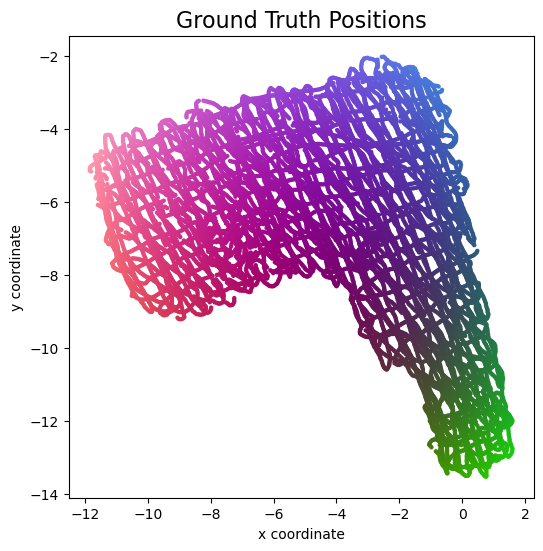

In [4]:
Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

In [5]:
def mean_variance_from_delta_adp(delta_adp):
    mean = np.where(delta_adp == 0, 0, np.where(delta_adp > 18, np.inf, delta_adp * 0.0028 + 0.0024))
    variance = np.where(delta_adp == 0, 0, np.where(delta_adp > 18, np.inf, 0.015 * mean))

    return mean, variance

adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain, mean_variance_from_delta_adp)

In [6]:
velocity_mean = 0.235
velocity_variance = 0.015

# Make worste-case assumption of perfectly correlated velocities. This maximizes the variance.
velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, timestamps)

In [7]:
GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric])
GDM.generate_short_paths(total_path_count = 4000, realization_count = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/83404000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/4000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Contracting paths for metric VelocityDissimilarityMetric
2821958 path sections remain to be contracted
1033462 path sections remain to be contracted
232834 path sections remain to be contracted
834 path sections remain to be contracted
0 path sections remain to be contracted
Determining longest short path...


Computing longest paths:   0%|          | 0/4000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/4000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/32 [00:00<?, ?it/s]

Longest short path has 334 hops


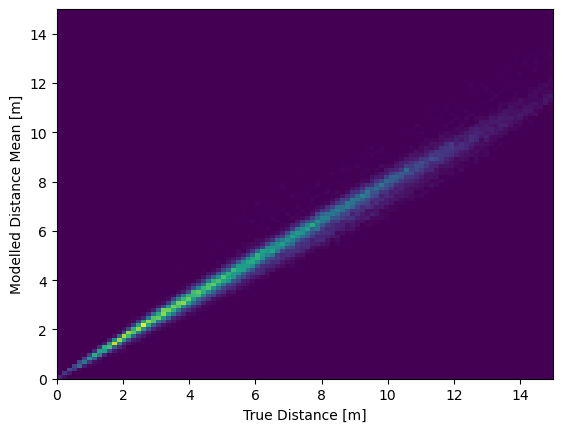

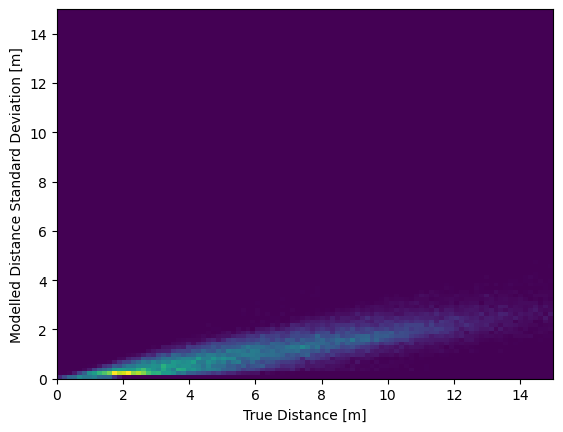

In [8]:
paths, path_hops, paths_d_mean, paths_d_variance = GDM.get_random_short_paths(50000, None)
groundtruth_distance_matrix = np.sqrt(np.sum((groundtruth_positions[:,np.newaxis,:] - groundtruth_positions[np.newaxis,:,:])**2, axis = -1))
groundtruth_dist = np.sum(groundtruth_distance_matrix[paths[:,:-1], paths[:,1:]], axis = 1).flatten()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Mean [m]")
plt.hist2d(groundtruth_dist, paths_d_mean, bins = 100, range = [(0, 15), (0, 15)])
plt.show()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Standard Deviation [m]")
plt.hist2d(groundtruth_dist, np.sqrt(paths_d_variance), bins = 100, range = [(0, 15), (0, 15)])
plt.show()

In [67]:
MIN_BATCH_SIZE = 2500
MAX_BATCH_SIZE = 3000
LEARNING_RATE_INITIAL = 3.5e-2
LEARNING_RATE_FINAL = 5e-3
MIN_PATHHOPS = 1
MAX_PATHHOPS = 20
TRAINING_BATCHES = 2200
ACCELERATION_MEAN = 0
ACCELERATION_VARIANCE = 1
ACCELERATION_WEIGHT = 1e-4

In [68]:
import importlib
importlib.reload(ChannelChartingCore)

<module 'ChannelChartingCore' from '/home/jovyan/Geodesic-Uncertainty-Loss-ChannelCharting/ChannelChartingCore.py'>

* **Note**: The neural network may not find the global optimum every time, resulting in higher than usual loss.
* Better initialization / pre-training (on e.g. generated free-space data) / higher initial learning rates would likely fix this issue, but are outside the scope of this work.

Pre-computing training paths:   0%|          | 0/2205 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/2205 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/32 [00:00<?, ?it/s]

 199/2200 [=>............................] - ETA: 1:42 - loss: 3.4431 - metric: 0.0000e+00

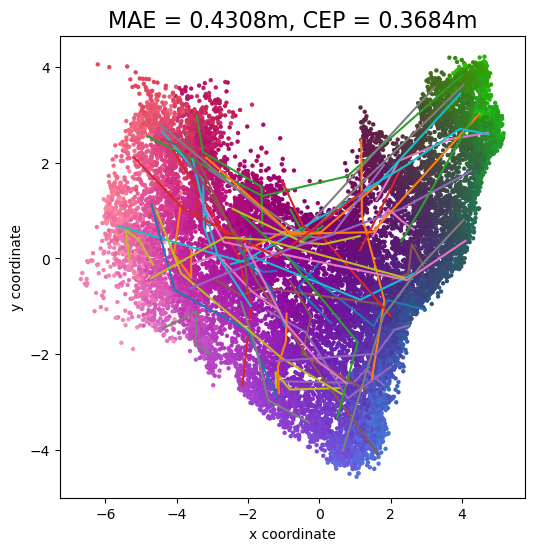

 399/2200 [====>.........................] - ETA: 1:32 - loss: 2.1804 - metric: 0.0000e+00

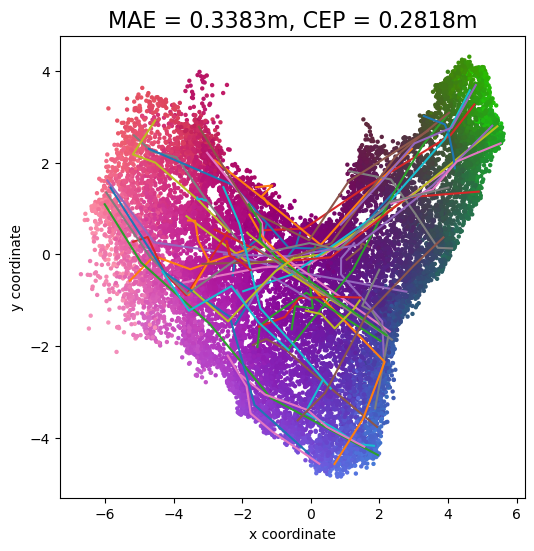

 599/2200 [=======>......................] - ETA: 1:22 - loss: 1.6562 - metric: 0.0000e+00

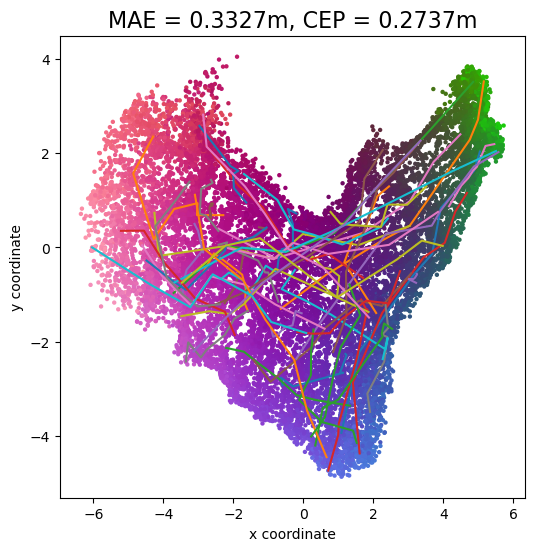

 799/2200 [=========>....................] - ETA: 1:12 - loss: 1.3501 - metric: 0.0000e+00

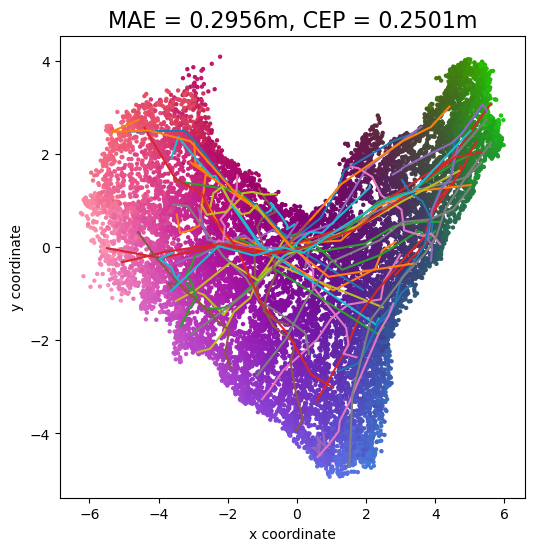

 999/2200 [============>.................] - ETA: 1:02 - loss: 1.1398 - metric: 0.0000e+00

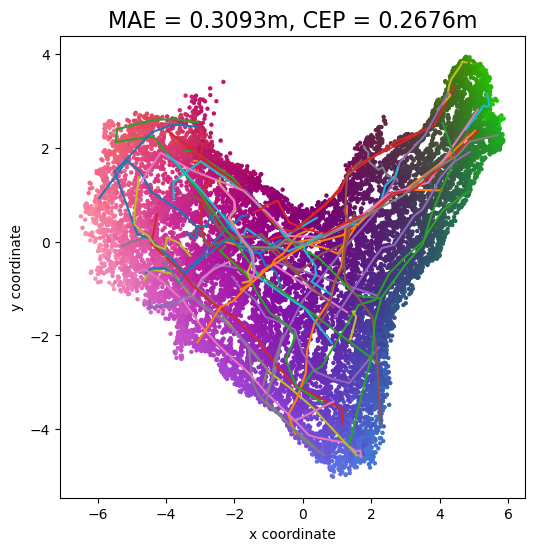

1199/2200 [===============>..............] - ETA: 51s - loss: 0.9854 - metric: 0.0000e+00

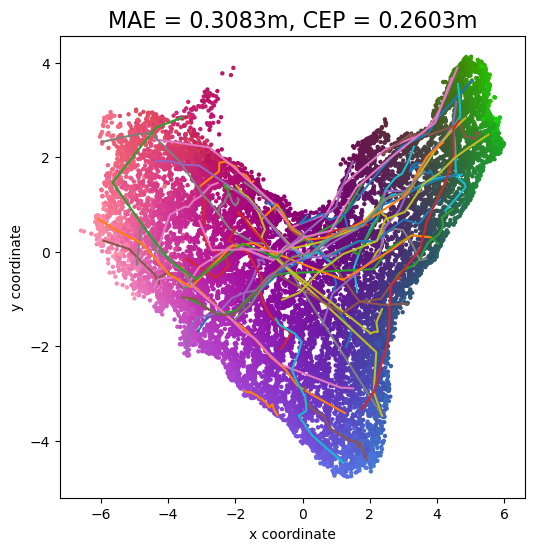

1399/2200 [==================>...........] - ETA: 41s - loss: 0.8685 - metric: 0.0000e+00

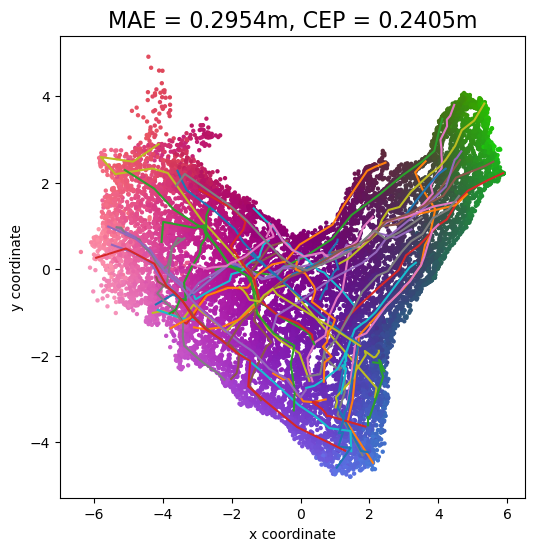

1599/2200 [====================>.........] - ETA: 31s - loss: 0.7747 - metric: 0.0000e+00

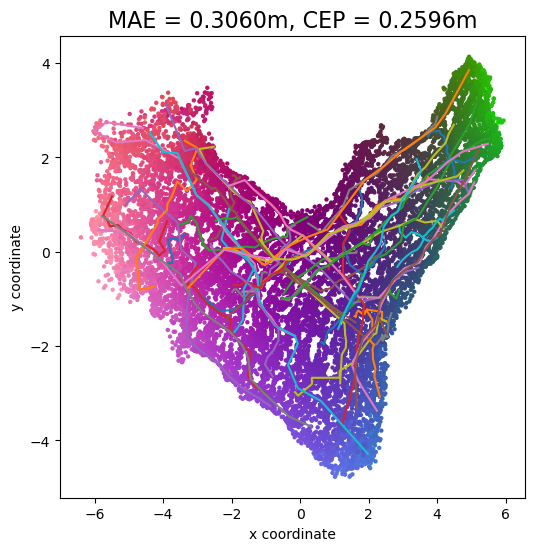

1799/2200 [=======================>......] - ETA: 20s - loss: 0.7014 - metric: 0.0000e+00

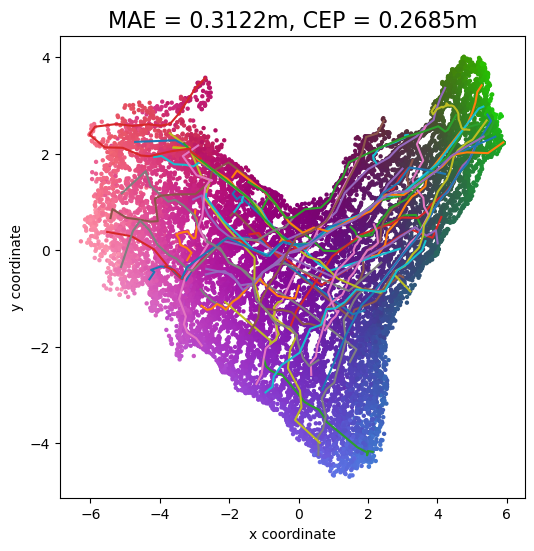

1999/2200 [==========================>...] - ETA: 10s - loss: 0.6382 - metric: 0.0000e+00

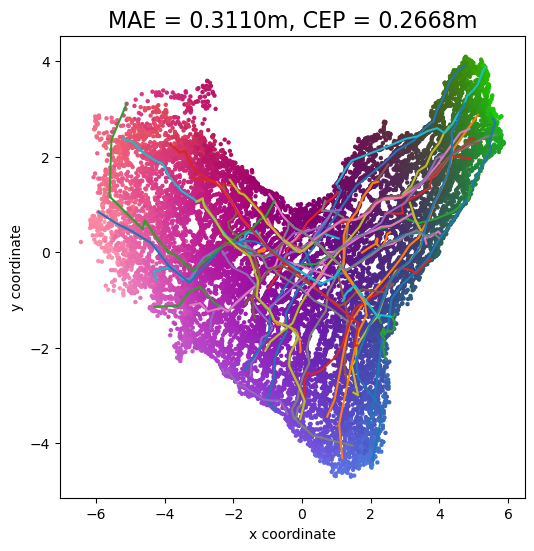

2199/2200 [============================>.] - ETA: 0s - loss: 0.5850 - metric: 0.0000e+00

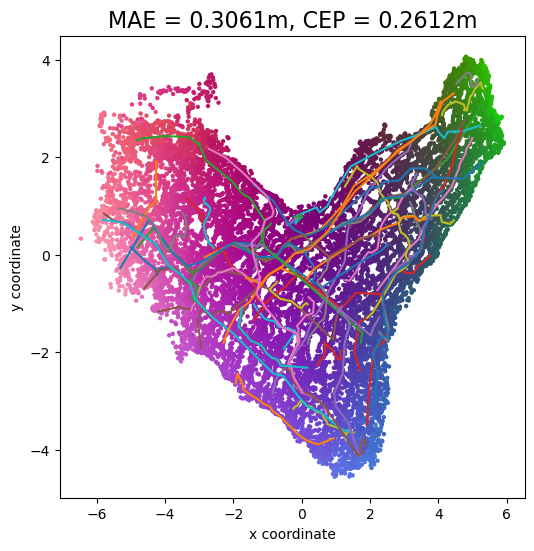

2200/2200 [==============================] - 118s 52ms/step - loss: 0.5848 - metric: 0.0000e+00


Process Process-308:
Process Process-319:
Process Process-317:
Process Process-311:
Process Process-327:
Process Process-322:
Process Process-321:
Process Process-328:
Process Process-316:
Traceback (most recent call last):
Process Process-329:
Process Process-300:
Process Process-314:
Process Process-320:
Process Process-326:
Process Process-306:
Process Process-318:
Traceback (most recent call last):
Process Process-309:
Process Process-307:
Process Process-313:
Traceback (most recent call last):
Process Process-299:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-302:
Process Process-330:
Process Process-325:
Process Process-323:
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-305:
Process Process-304:
Process Process-315:
Process Process-

In [69]:
plot_callback = Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain.shape[0], MAX_PATHHOPS)
cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, min_pathhops = MIN_PATHHOPS, max_pathhops = MAX_PATHHOPS, randomize_pathhops = False, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT)

In [70]:
channel_chart_positions = cc.predict(csi_time_domain)

652/652 [==============================] - 2s 2ms/step


In [71]:
ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

CT: 0.9976
TW: 0.9980
KS: 0.0664


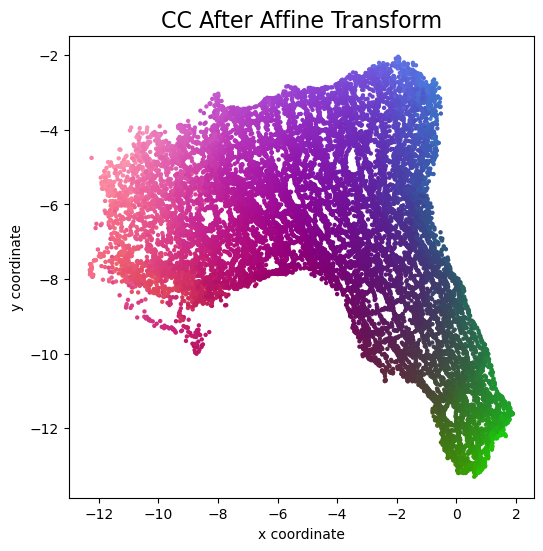

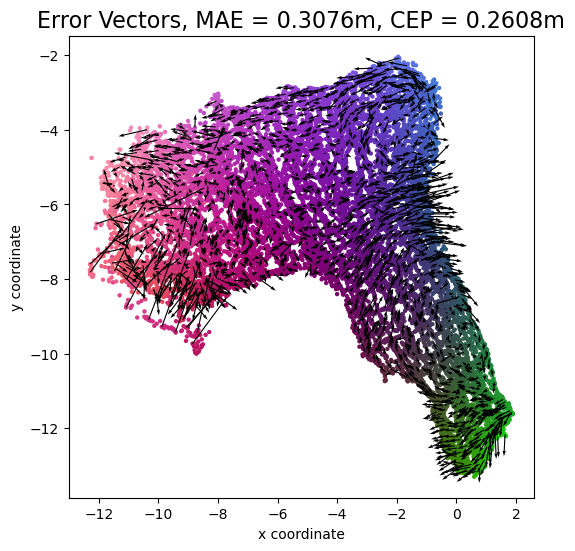

In [72]:
channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = f"Error Vectors, MAE = {mae:.4f}m, CEP = {cep:.4f}m", show = False)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

### Evaluate on Test set

In [73]:
test_set_groundtruth_positions = []
test_set_csi_time_domain = []

for csi, pos, time in dichasus_cf0x.testset.batch(1000):
    test_set_csi_time_domain.append(csi.numpy())
    test_set_groundtruth_positions.append(pos.numpy())

test_set_csi_time_domain = np.concatenate(test_set_csi_time_domain)
test_set_groundtruth_positions = np.concatenate(test_set_groundtruth_positions)

In [74]:
test_set_channel_chart_positions = cc.predict(test_set_csi_time_domain)

652/652 [==============================] - 1s 2ms/step


In [75]:
ts_ct, ts_tw, ts_ks = Evaluation.ct_tw_ks_on_subset(test_set_groundtruth_positions, test_set_channel_chart_positions)
print(f"CT: {ts_ct:.4f}\nTW: {ts_tw:.4f}\nKS: {ts_ks:.4f}")

CT: 0.9976
TW: 0.9981
KS: 0.0670


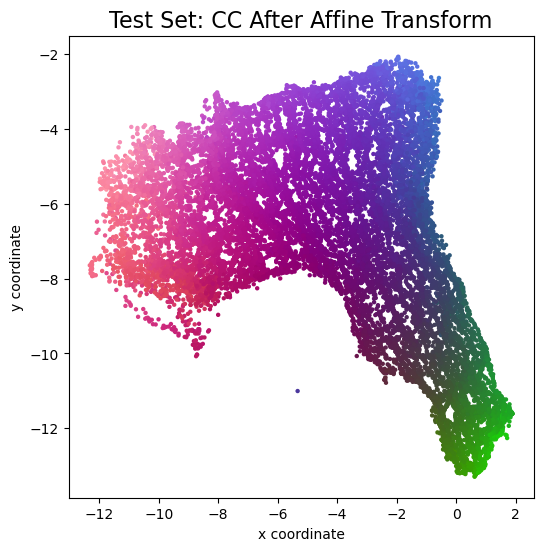

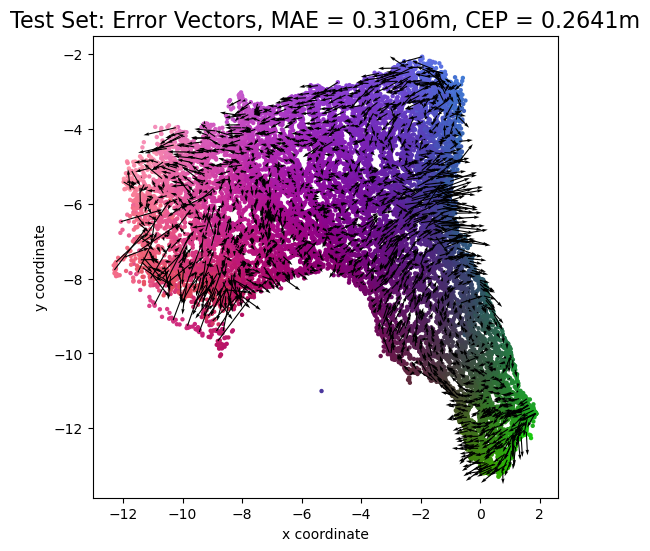

In [76]:
test_set_channel_chart_positions_transformed, ts_errorvectors, ts_errors, ts_mae, ts_cep = Evaluation.mean_absolute_error_transformed(test_set_groundtruth_positions, test_set_channel_chart_positions)
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = "Test Set: CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = f"Test Set: Error Vectors, MAE = {ts_mae:.4f}m, CEP = {ts_cep:.4f}m", show = False)
plt.quiver(test_set_channel_chart_positions_transformed[::nth_errorvector, 0], test_set_channel_chart_positions_transformed[::nth_errorvector, 1], ts_errorvectors[::nth_errorvector, 0], ts_errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()